In [4]:
from mp_api.client import MPRester
from api_key import APIKEY
import csv
API_KEY = APIKEY

In [5]:
mpids = []

with open('mpids.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        mpids.append(row[0])

In [6]:
materials = mpids[:5]
bandstruct = []
failed_ids = []

with MPRester(API_KEY) as mpr:
    for mp_id in materials:
        try:
            band_structure = mpr.get_bandstructure_by_material_id(mp_id)
            bandstruct.append(band_structure)
        except Exception as e:
            print(f"Failed to retrieve band structure for {mp_id}: {e}")
            failed_ids.append(mp_id)

# Remove the failed IDs from the materials list
for id in failed_ids:
    materials.remove(id)

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to retrieve band structure for mp-568392: No setyawan_curtarolo band structure data found for mp-568392


Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
mp_entries = []

with MPRester(API_KEY) as mpr:
    for mp_id in materials:
        material_entries = mpr.materials.search(material_ids=[mp_id])
        
        if material_entries:
            mp_entries.append(material_entries[0])

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
print(len(mp_entries),len(bandstruct))
chemsys_list = [entry.chemsys for entry in mp_entries if hasattr(entry, 'chemsys')]
composition_list = [entry.composition_reduced for entry in mp_entries if hasattr(entry, 'composition_reduced')] 
materials_gga = [material + "-GGA" for material in materials]
materials_id = materials

4 4


In [10]:
bandgaps = []

for i in bandstruct:
    bandgap = i.get_band_gap()
    bandgapenergy = bandgap.get('energy')
    bandgaps.append(bandgapenergy)

electroneg = []

for i in composition_list:
    electroneg.append(i.average_electroneg)

cbm = []
vbm = []

for i,x in zip(bandgaps,electroneg):

    bandcorrection = (i + 0.85)/2
    cbm_pre = x + bandcorrection
    vbm_pre = x - bandcorrection
    cbm_minusvac = cbm_pre - 4.5
    vbm_minusvac = vbm_pre - 4.5

    cbm.append(cbm_minusvac)
    vbm.append(vbm_minusvac)

band_edge = list(zip(cbm, vbm, materials))

CO_reduction_met = [item for item in band_edge if item[0] >= 0.12]
CO_reduction_below = [item for item in band_edge if 0 <= item[0] < 0.12]

print("above CO:",len(CO_reduction_met),"||","below CO:",len(CO_reduction_below))

cbms_above = [item[0] for item in CO_reduction_met]
vbms_above = [item[1] for item in CO_reduction_met]
mps_above = [item[2] for item in CO_reduction_met]

cbms_below = [item[0] for item in CO_reduction_below]
vbms_below = [item[1] for item in CO_reduction_below]
mps_below = [item[2] for item in CO_reduction_below]


above CO: 0 || below CO: 0


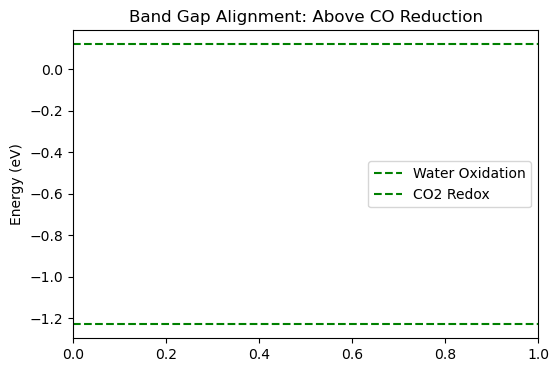

In [11]:
import matplotlib.pyplot as plt

water_oxidation = -1.23
co_reduction = 0.12

plt.figure(figsize=(6, 4))

for i in range(len(CO_reduction_met)):
    plt.hlines(cbms_above[i], i - 0.1, i + 0.1, colors='blue', label='CBM' if i == 0 else "")
    plt.hlines(vbms_above[i], i - 0.1, i + 0.1, colors='red', label='VBM' if i == 0 else "")

plt.axhline(y=water_oxidation, color='green', linestyle='--', label='Water Oxidation')
plt.axhline(y=co_reduction, color='green', linestyle='--', label='CO2 Redox')

# Adding labels and title
plt.ylabel('Energy (eV)')
plt.title('Band Gap Alignment: Above CO Reduction')
plt.legend()

# Show the plot
plt.show()